In [1]:
### This trial notebook works to predict the ternary diagram for R32/R125/hmimCl at 0.2 MPa, 298 K

In [2]:

from pyomo.environ import (Constraint,
                           Var,
                           ConcreteModel,
                           Expression,
                           Param,
                           Objective,
                           SolverFactory,
                           TransformationFactory,
                           value)

from pyomo.network import Arc, SequentialDecomposition

from idaes.core.util.initialization import propagate_state

# Import plotting functions
import matplotlib.pyplot as plt

# Import numpy library 
import numpy as np

# Import the main FlowsheetBlock from IDAES. The flowsheet block will contain the unit model
from idaes.core import FlowsheetBlock

import idaes.logger as idaeslog
from pyomo.opt import TerminationCondition, SolverStatus

# Import the degrees_of_freedom function from the idaes.core.util.model_statistics package
# DOF = Number of Model Variables - Number of Model Constraints
from idaes.core.util.model_statistics import degrees_of_freedom

# Import the Generic Parameter Block
from idaes.generic_models.properties.core.generic.generic_property import (
        GenericParameterBlock)

# Import unit models from the model library
from idaes.generic_models.unit_models import Flash

In [3]:
# import ternary params 
from HFCS_hmimCl_PR import configuration

## Create Model

In [4]:
# Create the ConcreteModel and the FlowsheetBlock, and attach the flowsheet block to it.
m = ConcreteModel()

m.fs = FlowsheetBlock(default={"dynamic": False}) 

# Add properties parameter blocks to the flowsheet with specifications
m.fs.props = GenericParameterBlock(default=configuration)

2021-05-05 10:56:08 [INFO] idaes.generic_models.properties.core.generic.generic_property: DEPRECATED - definiton of generic property packages is moving to using static classes instead of modules. Please refer to the IDAES documentation.


In [5]:
m.fs.F101 = Flash(default={"property_package": m.fs.props,
                               "has_heat_transfer": True,
                               "has_pressure_change": True})

# Call the degrees_of_freedom function, get intitial DOF
DOF_initial = degrees_of_freedom(m)
print("The initial DOF is {0}".format(DOF_initial))

The initial DOF is 8


In [6]:
solver = SolverFactory('ipopt')
solver.options = {'tol': 1e-6}

In [7]:
# Fix Heater H101 inlet conditions
m.fs.F101.inlet.mole_frac_comp[0, "R32"].fix(0.5)
m.fs.F101.inlet.mole_frac_comp[0, "R125"].fix(0.5)
m.fs.F101.inlet.mole_frac_comp[0, "hmimCl"].fix(0.001)

m.fs.F101.inlet.flow_mol[0].fix(1)
m.fs.F101.inlet.temperature.fix(300)
m.fs.F101.inlet.pressure.fix(200000)

# Fix F101 Flash outlet conditions
m.fs.F101.vap_outlet.temperature.fix(300)
m.fs.F101.deltaP.fix(0)

DOF_final = degrees_of_freedom(m)
print("The final DOF is {0}".format(DOF_final))

The final DOF is 0


In [8]:
IL_z = [0.1,0.4,0.72,0.91,0.99] # changed 0.001 to 0.01 bc infeasible
IL_x = np.zeros((len(IL_z)))
IL_y = np.zeros((len(IL_z)))
R32_x = np.zeros((len(IL_z)))
R32_y = np.zeros((len(IL_z)))
R125_x = np.zeros((len(IL_z)))
R125_y = np.zeros((len(IL_z))) 
Z = []

for j in range(len(IL_z)):

    fract = 1 - IL_z[j] #Think about this
    m.fs.F101.inlet.mole_frac_comp[0, "R32"].fix(0.85*IL_z[j])
    m.fs.F101.inlet.mole_frac_comp[0, "R125"].fix(0.85*fract)
    m.fs.F101.inlet.mole_frac_comp[0, "hmimCl"].fix(0.15)   
                  
    m.fs.F101.initialize(outlvl=idaeslog.CRITICAL)              
    # solve the model
    status = solver.solve(m, tee = False)
    # model.display()
    # If solution is optimal store the concentration, and calculated temperatures in the created arrays
    if (status.solver.status == SolverStatus.ok) and (status.solver.termination_condition == TerminationCondition.optimal):

        IL_x[j] = value(m.fs.F101.liq_outlet.mole_frac_comp[0, "hmimCl"])
        IL_y[j] = value(m.fs.F101.vap_outlet.mole_frac_comp[0, "hmimCl"])
        R32_x[j] = value(m.fs.F101.liq_outlet.mole_frac_comp[0, "R32"]) 
        R32_y[j] = value(m.fs.F101.vap_outlet.mole_frac_comp[0, "R32"])
        R125_x[j] = value(m.fs.F101.liq_outlet.mole_frac_comp[0, "R125"])
        R125_y[j] = value(m.fs.F101.vap_outlet.mole_frac_comp[0, "R125"])

        #Change this to feasible
        print(value(m.fs.F101.liq_outlet.flow_mol[0]))
        print(value(m.fs.F101.vap_outlet.flow_mol[0]))
    else:
        print('Infeasible.')

0.1741105327641192
0.8258894672358807
0.1710304287292288
0.8289695712707712
0.16796306819900622
0.8320369318009938
0.16623760066615414
0.8337623993338459
0.16553089741035437
0.8344691025896458


In [9]:
print("IL_x =", IL_x)
print("IL_y =", IL_y)
print("R32_x =", R32_x)
print("R32_y =", R32_y)
print("R125_x =", R125_x)
print("R125_y =", R125_y)

IL_x = [0.86152169 0.87703692 0.89305346 0.90232294 0.90617524]
IL_y = [1.e-08 1.e-08 1.e-08 1.e-08 1.e-08]
R32_x = [0.00961592 0.03806106 0.06779292 0.08517634 0.09243963]
R32_y = [0.10089215 0.4022951  0.72185893 0.91073967 0.99008865]
R125_x = [0.12886239 0.08490202 0.03915361 0.01250073 0.00138513]
R125_y = [0.89910785 0.5977049  0.27814107 0.08926033 0.00991135]


## Store Ternary Data

In [10]:
points_x = []

for i in range(len(IL_z)):
    points = (IL_x[i], R32_x[i], R125_x[i])
    points_x.append(points)
    
print(points_x)

points_y = []

for i in range(len(IL_z)):
    points = (IL_y[i], R32_y[i], R125_y[i])
    points_y.append(points)
    
print(points_y)

[(0.861521687508799, 0.009615920672274401, 0.1288623918189267), (0.8770369174334255, 0.038061063667055764, 0.08490201889951869), (0.8930534647192608, 0.06779292289344853, 0.03915361238729073), (0.9023229365613665, 0.08517633803688542, 0.012500725401747981), (0.9061752358313829, 0.09243963245046066, 0.0013851317181563182)]
[(1e-08, 0.10089215353188938, 0.8991078464681107), (1e-08, 0.40229510409158675, 0.5977048959084131), (1e-08, 0.7218589340362264, 0.2781410659637737), (1e-08, 0.9107396670057464, 0.08926033299425362), (1e-08, 0.9900886469252216, 0.009911353074778346)]


## Plot Diagram

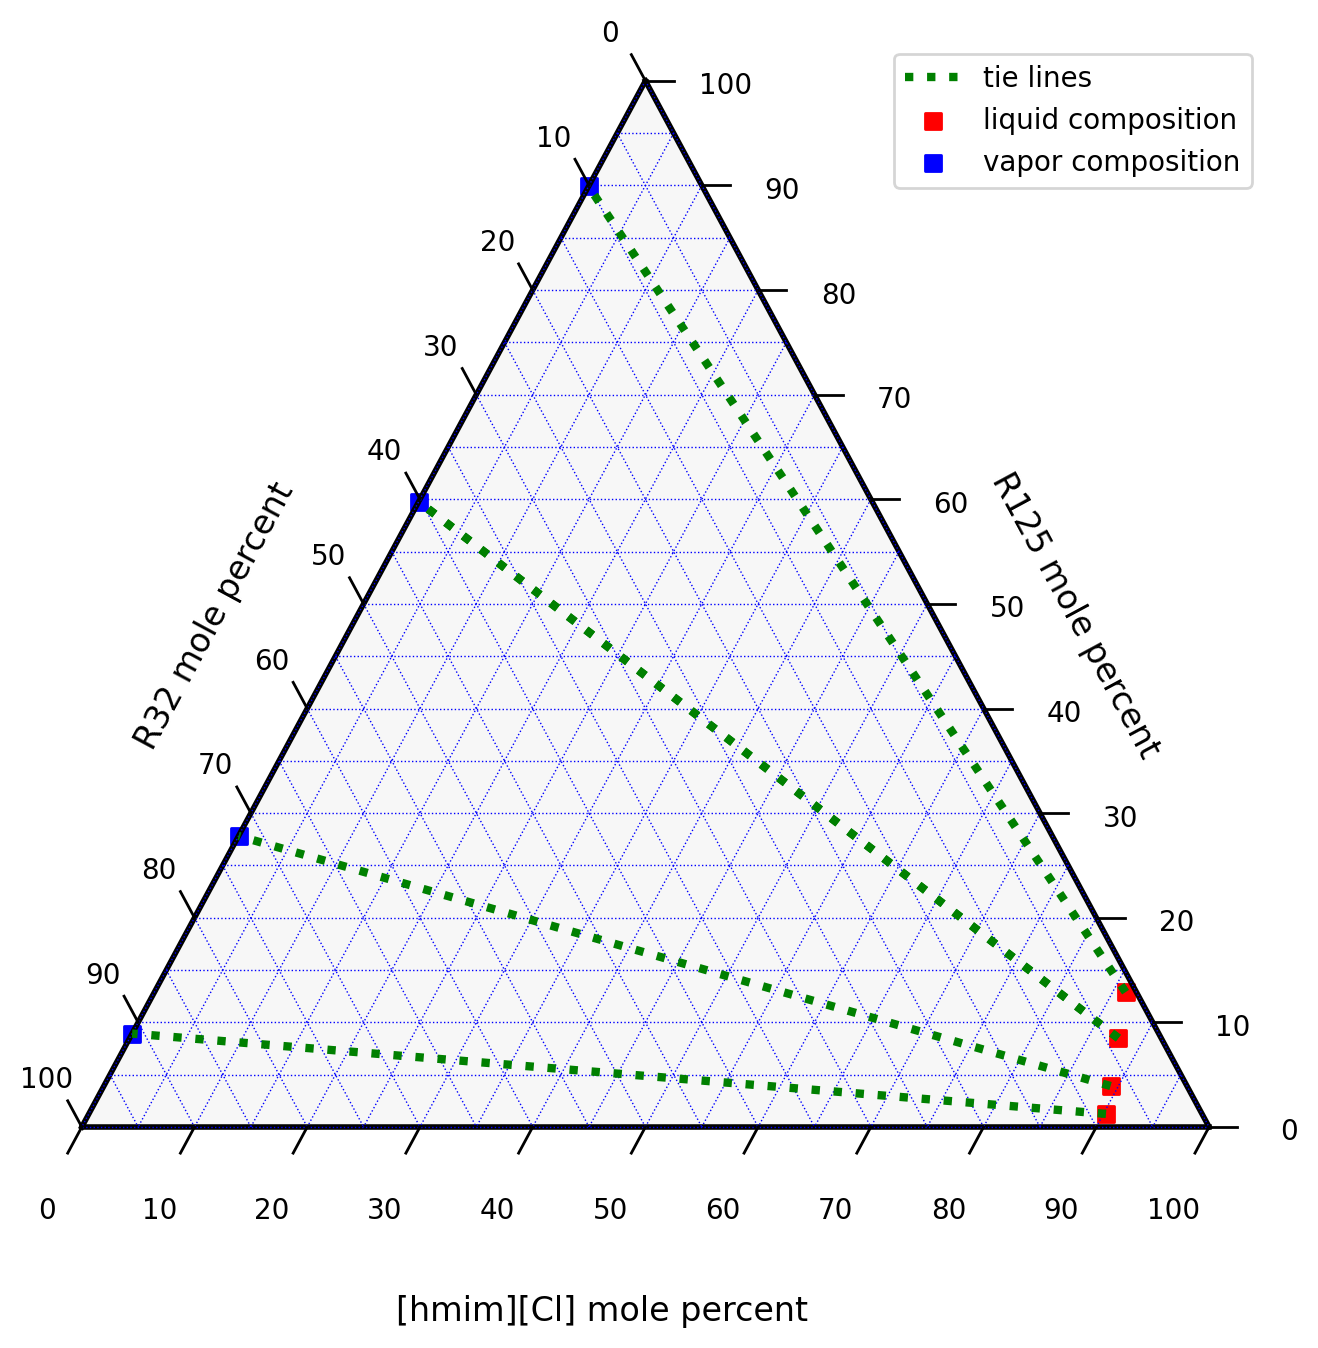

In [14]:
points_x = []

for i in range(0,4): #to shift how points are printed, shift the order
    points = (IL_x[i]*100, R125_x[i]*100, R32_x[i]*100)
    points_x.append(points)

points_y = []

for i in range(0,4): #to shift how points are printed, shift the order
    points = (IL_y[i]*100, R125_y[i]*100, R32_y[i]*100)
    points_y.append(points)

import ternary
import matplotlib
matplotlib.rcParams['figure.dpi'] = 200
matplotlib.rcParams['figure.figsize'] = (8, 8)    
    
scale = 100
figure, tax = ternary.figure(scale=scale)

# Draw Boundary and Gridlines
tax.boundary(linewidth=2.0)
tax.gridlines(color="blue", multiple=5)


fontsize = 12
offset = 0.14

# Set Axis labels and Title
fontsize = 12
offset = 0.14
# tax.set_title("Ternary phase diagram 8 bar\n", fontsize=24)
tax.left_axis_label("R32 mole percent" , fontsize=fontsize, offset=offset)
tax.right_axis_label("R125 mole percent", fontsize=fontsize, offset=offset)
tax.bottom_axis_label("[hmim][Cl] mole percent", fontsize=fontsize, offset=offset)

#for pressure changing plot would need to draw line between x[0] and x[final] for the indivual pressure
#use tax.line with the tax.scatter below
for i in range(4):
    tax.line(points_x[i], points_y[i], linewidth=3., color='green', linestyle=":")
tax.line(points_x[1], points_y[1], linewidth=3., color='green', linestyle=":", label="tie lines")
# make this tax.line
tax.scatter(points_x, marker='s', color='red', label="liquid composition")
#Comment out for pressure changing plot
tax.scatter(points_y, marker='s', color='blue', label="vapor composition")
tax.legend()
tax.ticks(axis='lbr', multiple=10, linewidth=1, offset=0.025)
tax.get_axes().axis('off')
tax.clear_matplotlib_ticks()
tax.show()